In [1]:
%matplotlib widget
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from joblib import Parallel, delayed
import statistics as st
import sympy as sym
from sklearn.metrics import mean_squared_error
from lmfit import Model, Parameters

In [2]:
filepath = "../data/01_raw/overall1.raw.h5"

obj = h5py.File(filepath, mode='r')
lsb = obj['settings']['lsb'][0] * 1e6

gain = (obj['settings']['gain'][0]).astype(int)
if 'lsb' in obj['settings']:
    lsb = obj['settings']['lsb'][0] * 1e6
else:
    lsb = 3.3 / (1024 * gain) * 1e6

mapping = obj.get('mapping')
channels = np.array(mapping['channel'])
electrodes = np.array(mapping['electrode'])

# remove unused channels
routed_idxs = np.where(electrodes > -1)[0]

channel_ids = list(channels[routed_idxs])
electrode_ids = list(electrodes[routed_idxs])
num_channels = len(electrode_ids)
num_frames = len(obj.get('sig')[0,:])
x_locs = list(np.array(mapping['x'][routed_idxs]))
y_locs = list(np.array(mapping['y'][routed_idxs]))

start_frame = 0
length = 100000
signals = (obj.get('sig')[np.array(channel_ids),start_frame:start_frame+length] * lsb).astype('float32') 

b, a = signal.butter(3,[100*2/2e4,2000*2/2e4],btype='band')
filtered = signal.filtfilt(b, a, signals)

In [3]:
def _peakseek(data, minpeakdist, minpeakh):
    """Find peaks in a 1D array."""
    locs = np.where((data[1:-1] >= data[0:-2]) & (data[1:-1] >= data[2:]))[0] + 1
    
    if minpeakh:
        locs = locs[data[locs] > minpeakh]

    if minpeakdist > 1:
        while 1:
            multi = (locs[1:] - locs[0:-1]) < minpeakdist
            if not any(multi):
                break
            pks = data[locs]
            all_pks = np.array([[pks[i] for i in range(len(multi)) if multi[i]], [pks[i+1] for i in range(len(multi)) if multi[i]]])
            min_ind = np.argmin(all_pks,axis=0)

            multi_x = np.where(multi)[0]
            multi_xx = list(multi_x[min_ind==0]) + list(multi_x[min_ind==1] + 1)
            locs = np.delete(list(locs), multi_xx)
    pks = data[locs]
    
    return list(locs), pks

def _R_timestamps(signal_single,mult_factor,min_peak_dist):
    """Identify R peaks in a single channel."""
    thr = mult_factor*np.std(signal_single)
    r_locs, a = _peakseek(signal_single, minpeakdist=min_peak_dist, minpeakh=thr)

    return len(r_locs), r_locs

In [4]:
mult_factor = 5.5
min_peak_dist=4000

channelIDs = [ch for ch in range(len(signals))]
# Parallel processing using all available CPUs
res = Parallel(n_jobs=1, backend='multiprocessing')([delayed(_R_timestamps)(filtered[ch],mult_factor,min_peak_dist) for ch in channelIDs])
n_Rpeaks, r_timestamps = map(list,zip(*res))

# identify synchronous beats
sync_beats = st.mode(n_Rpeaks)
# indices of channels where beats (R peaks) are synchronous
ind_sync_channels = [ind for ind,peaks in enumerate(n_Rpeaks) if peaks==sync_beats]
sync_timestamps = [r_timestamps[i] for i in ind_sync_channels]
sync_channelIDs = [channelIDs[i] for i in ind_sync_channels]

x_locs_updated = [x_locs[i] for i in ind_sync_channels]
y_locs_updated = [y_locs[i] for i in ind_sync_channels]

beat_clusters = np.vstack(sync_timestamps)

## Fit to polynomial surface

In [5]:
def polynomial_surface(x, y, a, b, c, d, e, f):
    return a*x**2 + b*y**2 + c*x*y + d*x + e*y + f

model = Model(polynomial_surface, independent_vars=['x', 'y'])

# activation time in seconds
t_data = (beat_clusters[:,0]-min(beat_clusters[:,0]))/20000 

params = Parameters()
params.add('a', value=1)
params.add('b', value=1)
params.add('c', value=1)
params.add('d', value=1)
params.add('e', value=1)
params.add('f', value=1)

x_locs_cm = np.array(x_locs_updated)*1e-4
y_locs_cm = np.array(y_locs_updated)*1e-4
result = model.fit(t_data, params, x=x_locs_cm, y=y_locs_cm)

a, b, c, d, e, f = [i.value for i in result.params.values()]
result.params

name,value,standard error,relative error,initial value,min,max,vary
a,0.20522091,0.00157322,(0.77%),1,-inf,inf,True
b,0.12915377,0.00572509,(4.43%),1,-inf,inf,True
c,-0.01577448,0.00270033,(17.12%),1,-inf,inf,True
d,-0.06843354,6.8121e-04,(1.00%),1,-inf,inf,True
e,-0.02071295,0.00131873,(6.37%),1,-inf,inf,True
f,0.00900294,9.0463e-05,(1.00%),1,-inf,inf,True


In [6]:
x, y = sym.symbols("x,y", real=True)
t_xy = a*x**2 + b*y**2 + c*x*y + d*x + e*y + f

# calculate partial derivatives
t_partial_x_eq = sym.lambdify([x, y], t_xy.diff(x), "numpy")
t_partial_y_eq = sym.lambdify([x, y], t_xy.diff(y), "numpy")

T_partial_x = t_partial_x_eq(x_locs_cm,y_locs_cm) 
T_partial_y = t_partial_y_eq(x_locs_cm,y_locs_cm)

# calculate dx/dT and dy/dT (conduction velocity)
velocity_x = T_partial_x / (T_partial_x**2 + T_partial_y**2)
velocity_y = T_partial_y / (T_partial_x**2 + T_partial_y**2)

# calculate magnitude of the vector (conduction speed)
speed = np.sqrt(velocity_x**2 + velocity_y**2)

print(np.mean(speed), np.std(speed))

35.61452309316643 49.6888892246715


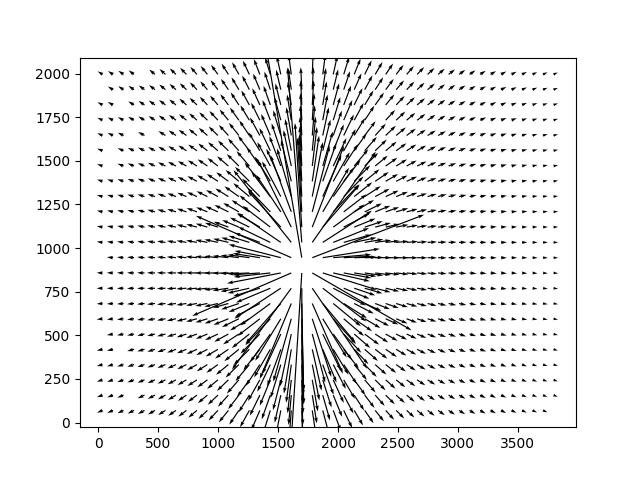

In [7]:
X = x_locs_updated
Y = y_locs_updated
U = velocity_x
V = velocity_y

# Plot the vectors
fig, ax = plt.subplots()
ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=0.3)

# Show the plot
plt.show()

Mean squared error: 2.9214242918523863e-07


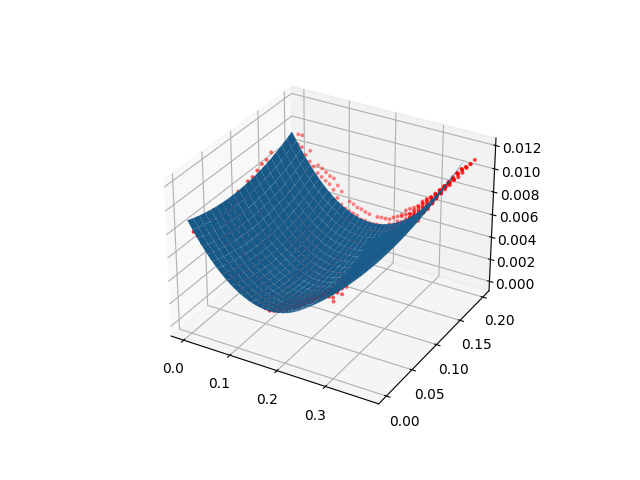

In [8]:
def polynomial(x, y):
    # return 0.2052*x**2 + 0.1291*y**2 - 0.01577*x*y - 0.06843*x - 0.02071*y + 0.009003
    return a*x**2 + b*y**2 + c*x*y + d*x + e*y + f

# Create a meshgrid of x and y values
x, y = np.meshgrid(np.arange(0,0.38,0.01), np.arange(0,0.2,0.01))

# Calculate the z values for each point in the meshgrid using the polynomial equation
z = polynomial(x, y)

print(f"Mean squared error: {mean_squared_error(t_data, polynomial(x_locs_cm, y_locs_cm))}")

# Plot the surface using the x, y, and z values
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z)
ax.scatter(x_locs_cm, y_locs_cm, t_data, c='r', marker='.', s=15)
plt.show()

## Fit cone

In [5]:
def cone_surface(x, y, x_p, y_p, a, b, c):
    return (a*(x-x_p)**2 + b*(y-y_p)**2)**0.5 + c

model = Model(cone_surface, independent_vars=['x', 'y'])

# activation time in seconds
t_data = (beat_clusters[:,0]-min(beat_clusters[:,0]))/20000 

params = Parameters()
params.add('x_p', value=0.2, min=-0.1, max=0.5)
params.add('y_p', value=0.1, min=-0.2, max=0.4)
params.add('a', value=1, min=1e-4)
params.add('b', value=1, min=1e-4)
params.add('c', value=1)

x_locs_cm = np.array(x_locs_updated)*1e-4
y_locs_cm = np.array(y_locs_updated)*1e-4
result = model.fit(t_data, params, x=x_locs_cm, y=y_locs_cm)

x_p, y_p, a, b, c = [i.value for i in result.params.values()]
result.params

name,value,standard error,relative error,initial value,min,max,vary
x_p,0.16752402,3.4554e-04,(0.21%),0.2,-0.10000000,0.50000000,True
y_p,0.09450363,8.5060e-04,(0.90%),0.1,-0.20000000,0.40000000,True
a,0.00226650,2.6500e-05,(1.17%),1,1.0000e-04,inf,True
b,0.00111601,4.5519e-05,(4.08%),1,1.0000e-04,inf,True
c,1.3609e-04,3.9218e-05,(28.82%),1,-inf,inf,True


In [6]:
x, y = sym.symbols("x,y", real=True)
t_xy = (a*(x-x_p)**2 + b*(y-y_p)**2)**0.5 + c

# calculate partial derivatives
t_partial_x_eq = sym.lambdify([x, y], t_xy.diff(x), "numpy")
t_partial_y_eq = sym.lambdify([x, y], t_xy.diff(y), "numpy")

T_partial_x = t_partial_x_eq(x_locs_cm,y_locs_cm) 
T_partial_y = t_partial_y_eq(x_locs_cm,y_locs_cm)

# calculate dx/dT and dy/dT (conduction velocity)
velocity_x = T_partial_x / (T_partial_x**2 + T_partial_y**2)
velocity_y = T_partial_y / (T_partial_x**2 + T_partial_y**2)

# calculate magnitude of the vector (conduction speed)
speed = np.sqrt(velocity_x**2 + velocity_y**2)

print(np.mean(speed), np.std(speed))

22.757669941307725 2.4016935583072994


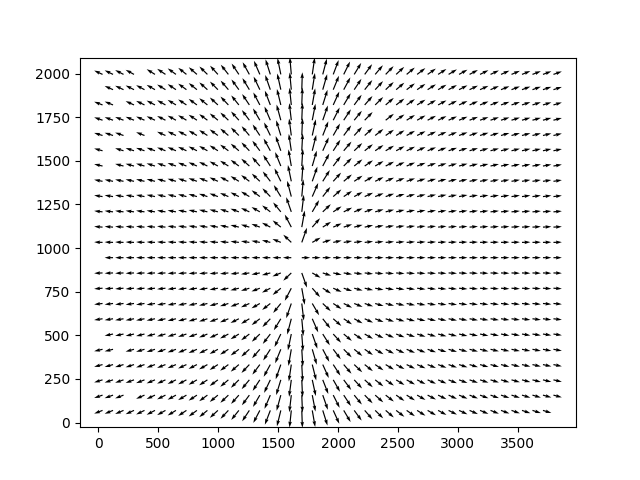

In [7]:
X = x_locs_updated
Y = y_locs_updated
U = velocity_x
V = velocity_y

# Plot the vectors
fig, ax = plt.subplots()
ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=0.3)

# Show the plot
plt.show()

Mean squared error: 1.8552830254524215e-07


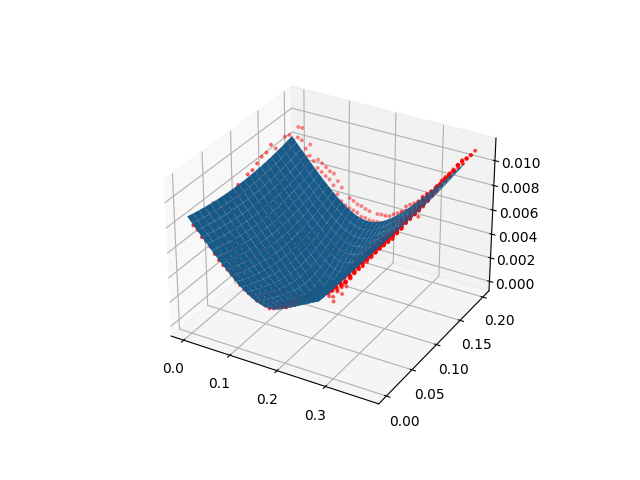

In [8]:
def cone(x, y):
    # return (0.00224*(x-0.166)**2 + 0.00111*(y-0.095)**2)**0.5 + 1.53e-4
    return (a*(x-x_p)**2 + b*(y-y_p)**2)**0.5 + c

# Create a meshgrid of x and y values
x, y = np.meshgrid(np.arange(0,0.38,0.01), np.arange(0,0.2,0.01))

# Calculate the z values for each point in the meshgrid using the polynomial equation
z = cone(x, y)

print(f"Mean squared error: {mean_squared_error(t_data, cone(x_locs_cm, y_locs_cm))}")

# Plot the surface using the x, y, and z values
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z)
ax.scatter(x_locs_cm, y_locs_cm, t_data, c='r', marker='.', s=15)
plt.show()